In [1]:
from __future__ import print_function
import os
import sys
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import datetime as datetime

In [2]:

#set current working directory
os.chdir('/Users/hanany/Downloads/Practical-Time-Series-Analysis-master')
#Read the dataset into a pandas.DataFrame
df = pd.read_csv('/Users/hanany/Desktop/lstm-GHI/data/dataGHIDNI_1ans_10m.txt',sep=',', engine='python')



In [3]:
print('Shape of the dataframe:', df.shape)

Shape of the dataframe: (27161, 3)


In [4]:
print(df.head())
print(df.info())

               DateTime        GHI       DNI
0  01-Jan-2016 08:01:00   1.521155  0.000000
1  01-Jan-2016 08:11:00   3.823183  0.000000
2  01-Jan-2016 08:21:00   7.175554  0.000000
3  01-Jan-2016 08:31:00  20.453589  1.549654
4  01-Jan-2016 08:41:00  19.065202  1.119731
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27161 entries, 0 to 27160
Data columns (total 3 columns):
DateTime    27161 non-null object
GHI         27161 non-null float64
DNI         27161 non-null float64
dtypes: float64(2), object(1)
memory usage: 636.7+ KB
None


In [6]:
df['DateTime']=pd.to_datetime(df['DateTime'])

print(df.head())
print(df.info())

             DateTime        GHI       DNI
0 2016-01-01 08:01:00   1.521155  0.000000
1 2016-01-01 08:11:00   3.823183  0.000000
2 2016-01-01 08:21:00   7.175554  0.000000
3 2016-01-01 08:31:00  20.453589  1.549654
4 2016-01-01 08:41:00  19.065202  1.119731
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27161 entries, 0 to 27160
Data columns (total 3 columns):
DateTime    27161 non-null datetime64[ns]
GHI         27161 non-null float64
DNI         27161 non-null float64
dtypes: datetime64[ns](1), float64(2)
memory usage: 636.7 KB
None


Text(0.5,1,'Box plot of GHI')

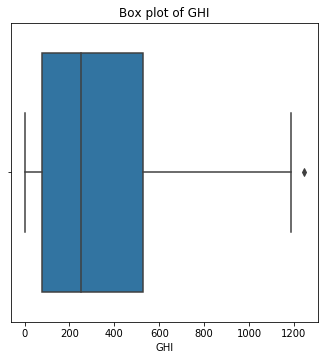

In [7]:
plt.figure(figsize=(5.5, 5.5))
g = sns.boxplot(df['GHI'])
g.set_title('Box plot of GHI')

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
df['scaled_GHI'] = scaler.fit_transform(np.array(df['GHI']).reshape(-1, 1))

In [9]:
# split into train and test sets
train_size = int(len(df.GHI) * 0.67)
df_train, df_val = df[:train_size], df[train_size+1:]



print('Shape of train:', df_train.shape)
print('Shape of test:', df_val.shape)

Shape of train: (18197, 4)
Shape of test: (8963, 4)


In [10]:
df_train.head()

,DateTime,GHI,DNI,scaled_GHI
0,2016-01-01 08:01:00,1.521155,0.000000,0.001054
1,2016-01-01 08:11:00,3.823183,0.000000,0.002905
2,2016-01-01 08:21:00,7.175554,0.000000,0.005601
3,2016-01-01 08:31:00,20.453589,1.549654,0.016281
4,2016-01-01 08:41:00,19.065202,1.119731,0.015164


In [11]:
df_val.head()

,DateTime,GHI,DNI,scaled_GHI
18198,2016-08-21 17:51:00,263.93287,689.95589,0.212114
18199,2016-08-21 18:01:00,233.07995,662.62451,0.187299
18200,2016-08-21 18:11:00,203.41456,636.21559,0.163439
18201,2016-08-21 18:21:00,174.62147,608.35700,0.140280
18202,2016-08-21 18:31:00,146.11541,572.09196,0.117352


In [12]:
df_val.reset_index(drop=True, inplace=True)

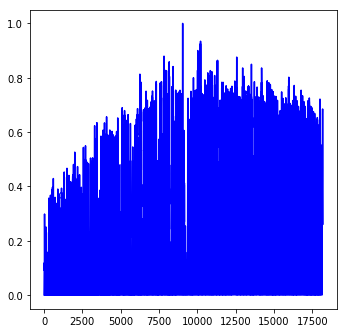

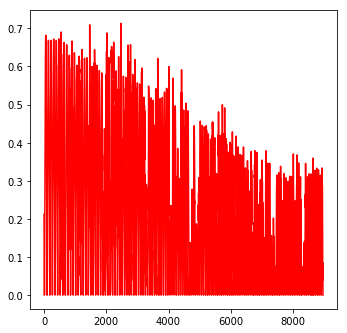

In [13]:
"""
The train and validation time series of standardized PRES are also plotted.
"""

plt.figure(figsize=(5.5, 5.5))
g = plt.plot(df_train['scaled_GHI'], color='b')
#g.set_title('Time series of scaled Air Pressure in train set')
#g.set_xlabel('Index')
#g.set_ylabel('Scaled Air Pressure readings')
#plt.savefig('plots/ch5/B07887_05_03.png', format='png', dpi=300)

plt.figure(figsize=(5.5, 5.5))
g = plt.plot(df_val['scaled_GHI'], color='r')
#g.set_title('Time series of scaled Air Pressure in validation set')
#g.set_xlabel('Index')
#g.set_ylabel('Scaled Air Pressure readings')
#plt.savefig('plots/ch5/B07887_05_04.png', format='png', dpi=300)

In [14]:
def makeXy(ts, nb_timesteps):
    """
    Input: 
           ts: original time series
           nb_timesteps: number of time steps in the regressors
    Output: 
           X: 2-D array of regressors
           y: 1-D array of target 
    """
    X = []
    y = []
    for i in range(nb_timesteps, ts.shape[0]):
        X.append(list(ts.loc[i-nb_timesteps:i-1]))
        y.append(ts.loc[i])
    X, y = np.array(X), np.array(y)
    return X, y

In [15]:
dimInput=10
X_train, y_train = makeXy(df_train['scaled_GHI'], dimInput)
print('Shape of train arrays:', X_train.shape, y_train.shape)

Shape of train arrays: (18187, 10) (18187,)


In [16]:
X_val, y_val = makeXy(df_val['scaled_GHI'], dimInput)
print('Shape of validation arrays:', X_val.shape, y_val.shape)

Shape of validation arrays: (8953, 10) (8953,)


In [17]:
from keras.layers import Dense, Input, Dropout
from keras.optimizers import SGD
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

//anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [18]:
#Define input layer which has shape (None, 7) and of type float32. None indicates the number of instances
input_layer = Input(shape=(dimInput,), dtype='float32')

In [19]:
#Dense layers are defined with linear activation
dense1 = Dense(64, activation='relu')(input_layer)
dense2 = Dense(32, activation='relu')(dense1)
dense3 = Dense(32, activation='relu')(dense2)
dense4 = Dense(32, activation='relu')(dense3)

In [20]:
dropout_layer = Dropout(0.2)(dense4)

In [21]:
#Finally, the output layer gives prediction for the next day's air pressure.
output_layer = Dense(1, activation='relu')(dropout_layer)

In [22]:
ts_model = Model(inputs=input_layer, outputs=output_layer)
ts_model.compile(loss='mean_squared_error', optimizer='adam')
ts_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                704       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total para

In [23]:
save_weights_at = os.path.join('/Users/hanany/Downloads/Practical-Time-Series-Analysis-master', 'GHI_MLP_weights.{epoch:02d}-{val_loss:.4f}.hdf5')
print(save_weights_at)

/Users/hanany/Downloads/Practical-Time-Series-Analysis-master/GHI_MLP_weights.{epoch:02d}-{val_loss:.4f}.hdf5


In [24]:
save_best = ModelCheckpoint(save_weights_at, monitor='val_loss', verbose=0,
                            save_best_only=True, save_weights_only=False, mode='min',
                            period=1)


In [28]:
ts_model.fit(x=X_train, y=y_train, batch_size=500, epochs=200,
             verbose=1, callbacks=[save_best], validation_data=(X_val, y_val),
             shuffle=True)

Train on 18187 samples, validate on 8953 samples
Epoch 1/200
18187/18187 [==============================] - 0s 18us/step - loss: 0.0043 - val_loss: 0.0015
Epoch 2/200
18187/18187 [==============================] - 0s 17us/step - loss: 0.0042 - val_loss: 0.0017
Epoch 3/200
18187/18187 [==============================] - 0s 19us/step - loss: 0.0042 - val_loss: 0.0015
Epoch 4/200
18187/18187 [==============================] - 0s 16us/step - loss: 0.0042 - val_loss: 0.0015
Epoch 5/200
18187/18187 [==============================] - 0s 16us/step - loss: 0.0041 - val_loss: 0.0015
Epoch 6/200
18187/18187 [==============================] - 0s 15us/step - loss: 0.0041 - val_loss: 0.0015
Epoch 7/200
18187/18187 [==============================] - 0s 16us/step - loss: 0.0040 - val_loss: 0.0015
Epoch 8/200
18187/18187 [==============================] - 0s 15us/step - loss: 0.0040 - val_loss: 0.0015
Epoch 9/200
18187/18187 [==============================] - 0s 15us/step - loss: 0.0041 - val_loss: 0.00

18187/18187 [==============================] - 0s 23us/step - loss: 0.0035 - val_loss: 0.0015
Epoch 78/200
18187/18187 [==============================] - 0s 21us/step - loss: 0.0035 - val_loss: 0.0016
Epoch 79/200
18187/18187 [==============================] - 0s 20us/step - loss: 0.0035 - val_loss: 0.0016
Epoch 80/200
18187/18187 [==============================] - 0s 21us/step - loss: 0.0035 - val_loss: 0.0016
Epoch 81/200
18187/18187 [==============================] - 0s 20us/step - loss: 0.0035 - val_loss: 0.0016
Epoch 82/200
18187/18187 [==============================] - 0s 20us/step - loss: 0.0035 - val_loss: 0.0016
Epoch 83/200
18187/18187 [==============================] - 0s 22us/step - loss: 0.0035 - val_loss: 0.0016
Epoch 84/200
18187/18187 [==============================] - 0s 20us/step - loss: 0.0035 - val_loss: 0.0016
Epoch 85/200
18187/18187 [==============================] - 0s 23us/step - loss: 0.0036 - val_loss: 0.0016
Epoch 86/200
18187/18187 [========================

18187/18187 [==============================] - 1s 37us/step - loss: 0.0033 - val_loss: 0.0016
Epoch 154/200
18187/18187 [==============================] - 0s 27us/step - loss: 0.0033 - val_loss: 0.0016
Epoch 155/200
18187/18187 [==============================] - 0s 27us/step - loss: 0.0033 - val_loss: 0.0016
Epoch 156/200
18187/18187 [==============================] - 0s 26us/step - loss: 0.0033 - val_loss: 0.0016
Epoch 157/200
18187/18187 [==============================] - 1s 28us/step - loss: 0.0033 - val_loss: 0.0016
Epoch 158/200
18187/18187 [==============================] - 0s 27us/step - loss: 0.0033 - val_loss: 0.0016
Epoch 159/200
18187/18187 [==============================] - 0s 27us/step - loss: 0.0033 - val_loss: 0.0016
Epoch 160/200
18187/18187 [==============================] - 0s 23us/step - loss: 0.0033 - val_loss: 0.0016
Epoch 161/200
18187/18187 [==============================] - 0s 21us/step - loss: 0.0033 - val_loss: 0.0016
Epoch 162/200
18187/18187 [===============

In [29]:
best_model = load_model(os.path.join('/Users/hanany/Downloads/Practical-Time-Series-Analysis-master',
                                     'GHI_MLP_weights.20-0.0015.hdf5'))
preds = best_model.predict(X_val)
pred_PRES = scaler.inverse_transform(preds)
pred_PRES = np.squeeze(pred_PRES)

Text(0,0.5,'GHI')

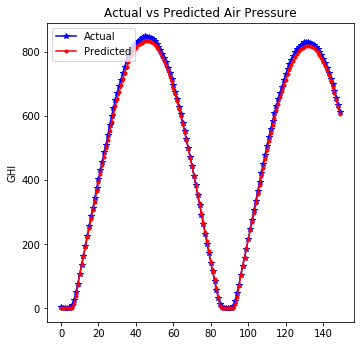

In [27]:
#Let's plot the first 50 actual and predicted values of air pressure.
tailPlot=150
plt.figure(figsize=(5.5, 5.5))
plt.plot(range(tailPlot), df_val['GHI'].loc[dimInput:tailPlot+dimInput-1], linestyle='-', marker='*', color='b')
plt.plot(range(tailPlot), pred_PRES[:tailPlot], linestyle='-', marker='.', color='r')
plt.legend(['Actual','Predicted'], loc=2)
plt.title('Actual vs Predicted Air Pressure')
plt.ylabel('GHI')

In [672]:
from sklearn.metrics import r2_score,mean_squared_error
r2 = r2_score(df_val['GHI'].loc[dimInput:], pred_PRES)
print('R-squared for the validation set:', round(r2,4))

# calculate root mean squared error
testScore = np.sqrt(mean_squared_error(df_val['GHI'].loc[dimInput:], pred_PRES))/np.mean(df_val['GHI'].loc[dimInput:])
print('Test Score: %.2f nRMSE' % (testScore))


#trainScore = np.sqrt(mean_squared_error(df_train['GHI'].loc[:dimInput], pred_PRES))/np.mean(df_val['GHI'].loc[dimInput:])
print('Test Score: %.2f RMSE' % (np.sqrt(mean_squared_error(df_val['GHI'].loc[dimInput:], pred_PRES))))
#testScore = np.sqrt(mean_squared_error(testYI[0], testPredictI[:,0]))
#print('Test Score: %.2f RMSE' % (testScore))
#print(len(df_val['GHI'].loc[dimInput:]),len(pred_PRES))


R-squared for the validation set: 0.9572
Test Score: 0.18 nRMSE
Test Score: 47.55 RMSE


In [464]:
#import plotly
#import plotly.graph_objs as go

#from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
#init_notebook_mode(connected=True)
#iplot([{"x": time, "y": df_val['GHI'].loc[dimInput:]},{"x": time, "y": pred_PRES}])
#iplot([{"x": time, "y": ssn}])